<a href="https://colab.research.google.com/github/Karthick47v2/FoodMenu/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libs

In [1]:
!pip install keras-tuner --upgrade
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 27.2 MB/s 


### Import data

In [7]:
df = pd.read_csv('train.csv')
# drop PassengerId, Name, Ticket
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

### Preprocessing

In [441]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B42,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C148,C


In [189]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [8]:
# drop Cabin as more than 50% data isn't avail
df.drop(columns=['Cabin'], inplace=True)

In [9]:
# fill null age values with mean
df['Age'].fillna(df['Age'].mean(), inplace=True)

In [10]:
# (1) drop 2 values with null Embarked          - TRIED 84%    86%
#            or
# (2) apply high frequent value, whihc is, S    - TRIED 85%    85%
# df.dropna(subset=['Embarked'], inplace=True)
df['Embarked'].fillna('S', inplace=True)

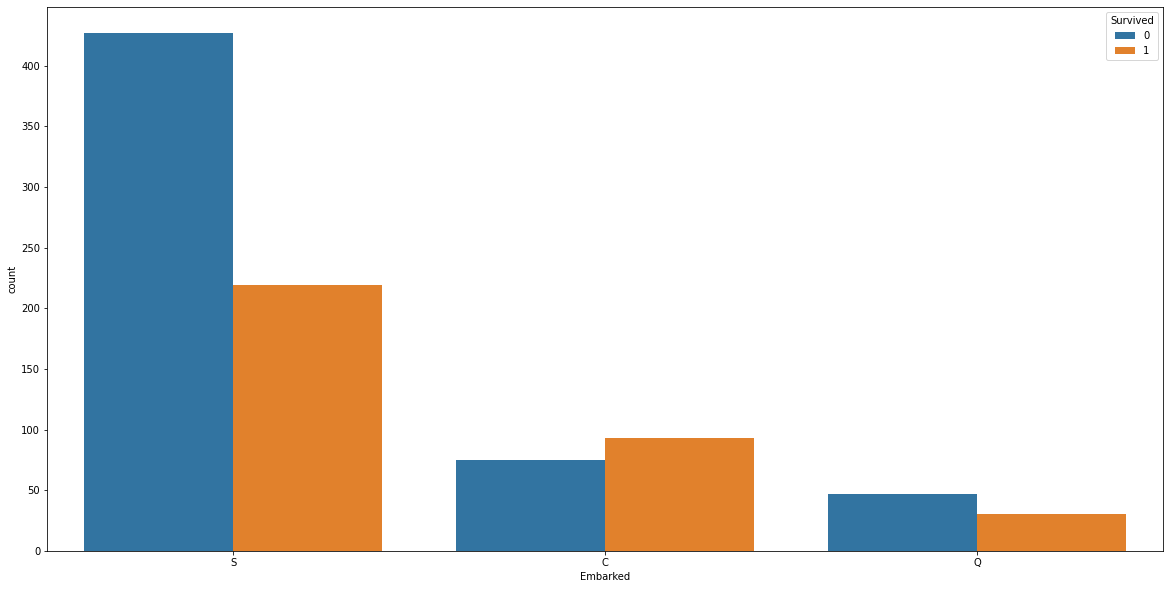

In [455]:
plt.figure(figsize=(20,10))
sns.countplot(x=df['Embarked'], hue='Survived', data=df)

- Most of people in Pclass 3 didn't survive
- Most of male didn't survive
- People with more SibSp or Parch have less chance of survival
- 

In [11]:
x = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [12]:
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['Sex', 'Embarked']), remainder='passthrough')
updated_x = pd.DataFrame(transformer.fit_transform(x), columns=transformer.get_feature_names_out())

In [13]:
sc = StandardScaler()
scaled_x = sc.fit_transform(updated_x)
x = pd.DataFrame(scaled_x, columns=updated_x.columns)

In [439]:
x

,onehotencoder__Sex_male,onehotencoder__Embarked_C,onehotencoder__Embarked_Q,onehotencoder__Embarked_S,remainder__Pclass,remainder__Age,remainder__SibSp,remainder__Parch,remainder__Fare
0,0.737695,-0.482043,-0.307562,0.615838,0.827377,-5.924806e-01,0.432793,-0.473674,-0.502445
1,-1.355574,2.074505,-0.307562,-1.623803,-1.566107,6.387890e-01,0.432793,-0.473674,0.786845
2,-1.355574,-0.482043,-0.307562,0.615838,0.827377,-2.846632e-01,-0.474545,-0.473674,-0.488854
3,-1.355574,-0.482043,-0.307562,0.615838,-1.566107,4.079260e-01,0.432793,-0.473674,0.420730
4,0.737695,-0.482043,-0.307562,0.615838,0.827377,4.079260e-01,-0.474545,-0.473674,-0.486337
...,...,...,...,...,...,...,...,...,...
886,0.737695,-0.482043,-0.307562,0.615838,-0.369365,-2.077088e-01,-0.474545,-0.473674,-0.386671
887,-1.355574,-0.482043,-0.307562,0.615838,-1.566107,-8.233437e-01,-0.474545,-0.473674,-0.044381
888,-1.355574,-0.482043,-0.307562,0.615838,0.827377,4.374348e-15,0.432793,2.008933,-0.176263
889,0.737695,2.074505,-0.307562,-1.623803,-1.566107,-2.846632e-01,-0.474545,-0.473674,-0.044381


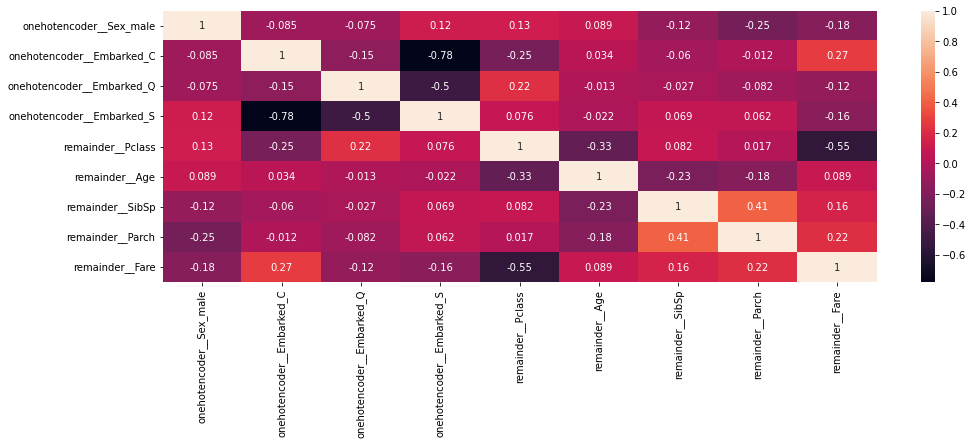

In [78]:
corr = x.corr()
plt.figure(figsize=(16, 5))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

### Hyperparameter tuning with Keras-Tuner

In [16]:
import keras_tuner as kt

def build_model(hp):
  model = keras.Sequential()

  model.add(keras.Input(shape=(9)))

  for i in range(hp.Int('num_layers', 1, 5)):
    model.add(keras.layers.Dense(hp.Int(f"units_{i}", min_value=2, max_value=512, step=16), activation='relu', kernel_initializer='he_normal'))

  # if hp.Boolean('dropout'):
  #   model.add(keras.layers.Dropout(0.3))

  model.add(keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer='glorot_normal'))

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('lr', min_value=1e-6, max_value=5e-2, sampling='log')),
                loss='binary_crossentropy', metrics=['binary_accuracy'])
  
  return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_binary_accuracy',
    max_trials=20,
    executions_per_trial=3,
    overwrite=True
)

tuner.search(x_train, y_train, epochs=20, validation_data=(x_test, y_test))

tuner.results_summary()

Trial 20 Complete [00h 00m 17s]
val_binary_accuracy: 0.8666666547457377

Best val_binary_accuracy So Far: 0.8740740617116293
Total elapsed time: 00h 04m 05s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 194
lr: 0.006110963402192558
units_1: 50
units_2: 146
units_3: 194
units_4: 66
Score: 0.8740740617116293
Trial summary
Hyperparameters:
num_layers: 4
units_0: 242
lr: 0.0017789751315692266
units_1: 370
units_2: 434
units_3: 402
units_4: 370
Score: 0.8666666547457377
Trial summary
Hyperparameters:
num_layers: 5
units_0: 50
lr: 0.005182023855375758
units_1: 322
units_2: 18
units_3: 290
units_4: 34
Score: 0.8629629611968994
Trial summary
Hyperparameters:
num_layers: 2
units_0: 258
lr: 0.021234073797604936
units_1: 258
units_2: 290
units_3: 146
units_4: 66
Score: 0.8629629413286845
Trial summary
Hyperparameters:
num_layers: 3
units_0: 434
lr: 0.006906898290827239
units_1: 34
un

### Train model

In [411]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.1, patience=5, mode='max', min_delta=1e-3, min_lr=1e-6)
tensorboard = keras.callbacks.TensorBoard(log_dir='logs/tuner', histogram_freq=1)

In [416]:
model = keras.Sequential()
model.add(keras.Input(shape=(8)))

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(units=16, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(units=8, activation='relu', kernel_initializer='he_normal'))

model.add(keras.layers.Dense(units=1, activation='sigmoid', kernel_initializer='glorot_normal'))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_93 (Dense)            (None, 32)                288       
                                                                 
 dense_94 (Dense)            (None, 16)                528       
                                                                 
 dense_95 (Dense)            (None, 8)                 136       
                                                                 
 dense_96 (Dense)            (None, 1)                 9         
                                                                 
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


In [417]:
model.fit(x_train, y_train, epochs=30, batch_size=64, validation_data=(x_test, y_test), callbacks=[reduce_lr, tensorboard])

Epoch 1/30
13/13 [==============================] - 2s 43ms/step - loss: 0.6518 - binary_accuracy: 0.7041 - val_loss: 0.4592 - val_binary_accuracy: 0.8222 - lr: 0.0200
Epoch 2/30
13/13 [==============================] - 0s 18ms/step - loss: 0.4566 - binary_accuracy: 0.8127 - val_loss: 0.4273 - val_binary_accuracy: 0.8333 - lr: 0.0200
Epoch 3/30
13/13 [==============================] - 0s 19ms/step - loss: 0.4318 - binary_accuracy: 0.8127 - val_loss: 0.4124 - val_binary_accuracy: 0.8444 - lr: 0.0200
Epoch 4/30
13/13 [==============================] - 0s 19ms/step - loss: 0.4138 - binary_accuracy: 0.8277 - val_loss: 0.3953 - val_binary_accuracy: 0.8444 - lr: 0.0200
Epoch 5/30
13/13 [==============================] - 0s 16ms/step - loss: 0.4207 - binary_accuracy: 0.8290 - val_loss: 0.4356 - val_binary_accuracy: 0.8444 - lr: 0.0200
Epoch 6/30
13/13 [==============================] - 0s 17ms/step - loss: 0.4087 - binary_accuracy: 0.8265 - val_loss: 0.4170 - val_binary_accuracy: 0.8333 - lr:

In [418]:
from sklearn.metrics import confusion_matrix
import numpy as np

confusion_matrix(y_test, np.where(model.predict(x_test) >= 0.6, 1, 0))

array([[50,  4],
       [10, 26]])

In [419]:
confusion_matrix(y_train, np.where(model.predict(x_train) >= 0.5, 1, 0))

array([[472,  23],
       [ 96, 210]])

In [420]:
test_df = pd.read_csv('test.csv')

In [389]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [421]:
test_df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

In [422]:
test_df.drop(columns=['Cabin'], inplace=True)

In [393]:
test_df.isnull().sum()

Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64

In [423]:
test_df['Age'].fillna(test_df['Age'].mean(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].mean(), inplace=True)

In [424]:
transformer = make_column_transformer((OneHotEncoder(drop='if_binary'), ['Sex', 'Embarked']), remainder='passthrough')
updated_df = pd.DataFrame(transformer.fit_transform(test_df), columns=transformer.get_feature_names_out())

sc = StandardScaler()
scaled_df = sc.fit_transform(updated_df)
test_df = pd.DataFrame(scaled_df, columns=updated_df.columns)

In [425]:
test_pred = model.predict(test_df)

In [426]:
test_pred = np.where(test_pred >= 0.5, 1, 0)

In [428]:
test_df = pd.read_csv('test.csv')

In [429]:
out_csv = pd.DataFrame({'PassengerId': test_df['PassengerId'].values, 'Survived': test_pred.squeeze()})

In [430]:
out_csv.to_csv('output.csv',index=False)